In [72]:
import json
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [73]:
from imputation import run_comparing, imputed_sqr_err, imputed_vals

In [74]:
seed = 42

In [75]:
random_state = np.random.RandomState(seed)
random_generator = np.random.default_rng(seed)

In [76]:
df = pd.read_csv("data/2-test_df.csv", index_col="Unnamed: 0")
df

,T3,FTI,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds
6364,0.3,77.0,68.0,49.0,0.88,68.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7417,1.9,119.0,99.0,73.0,0.83,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
982,1.3,128.0,109.0,62.0,0.85,0.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2909,2.2,115.0,124.0,72.0,1.08,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5633,2.0,119.0,136.0,63.0,1.14,1.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,2.6,111.0,131.0,74.0,1.18,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3083,1.2,24.0,36.0,17.0,1.50,145.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,2.2,108.0,122.0,79.0,1.13,2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5443,2.1,116.0,130.0,73.0,1.11,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
qualitative_cols_f = open('data/qualitative_cols.json', 'r')
categorical_cols_f = open('data/categorical_cols.json', 'r')

In [78]:
complete_vals_df = pd.read_csv("data/5-train_df.csv", index_col="Unnamed: 0") 
remove_vals_df = pd.read_csv("data/5-test_df.csv", index_col="Unnamed: 0") 
missing_vals_idxs = list(remove_vals_df.index)

sel_qual_cols = json.load(qualitative_cols_f)
sel_cat_cols = json.load(categorical_cols_f)

real_df = pd.concat([complete_vals_df, remove_vals_df])

In [79]:
neighbours = 10
iters = 10

## Non Weighted KNN

In [80]:
knn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    knn_imputer = KNNImputer(n_neighbors=neighbours)
    knn_imputed_mat = knn_imputer.fit_transform(curr_df)
    
    knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    knn_imputed_df["{} (real)".format(col)] = real_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

    knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

    knn_imputed_df_map[col] = knn_imputed_df

In [81]:
def col_mse(df : pd.DataFrame, col : str) -> float:
    sqr_err_list = (df[col + " (real)"] - df[col + " (imputed)"]).to_numpy() ** 2
    sqr_err_sum = sqr_err_list.sum()
    mean_sqr_err = sqr_err_sum / sqr_err_list.size
    return mean_sqr_err

In [82]:
for col, knn_imputed_df in knn_imputed_df_map.items():
    display("{} with KNN".format(col))
    display(col_mse(knn_imputed_df, col))
    display(knn_imputed_df)

'T3 with KNN'

0.36365717097320716

,FTI,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3 (real),T3 (imputed)
3196,153.0,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.09
1736,59.0,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.17
1836,126.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.87
4819,72.0,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,2.04
4300,129.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,97.0,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.8,2.15
8024,107.0,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.6,2.08
4111,67.0,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.90
2694,100.0,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,1.26


'FTI with KNN'

484.8367436264754

,T3,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,FTI (real),FTI (imputed)
3196,0.5,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,130.6
1736,1.8,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,97.2
1836,2.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,92.0
4819,2.3,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,87.2
4300,2.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,145.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,97.0,108.3
8024,2.6,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,107.0,98.6
4111,2.3,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,88.7
2694,1.9,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,91.5


'TT4 with KNN'

468.60274943820224

,T3,FTI,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TT4 (real),TT4 (imputed)
3196,0.5,153.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,127.3
1736,1.8,59.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,59.2
1836,2.0,126.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,110.3
4819,2.3,72.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,80.0
4300,2.0,129.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,116.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,91.0,95.0
8024,2.6,107.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,104.2
4111,2.3,67.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,76.5
2694,1.9,100.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,98.8


'age with KNN'

354.62072601555747

,T3,FTI,TT4,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,age (real),age (imputed)
3196,0.5,153.0,130.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,54.0
1736,1.8,59.0,81.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,58.8
1836,2.0,126.0,79.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,59.4
4819,2.3,72.0,68.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,60.2
4300,2.0,129.0,152.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,54.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0,59.1
8024,2.6,107.0,95.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,47.5
4111,2.3,67.0,73.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,62.2
2694,1.9,100.0,87.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,39.3


'T4U with KNN'

0.002450534001728608

,T3,FTI,TT4,age,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T4U (real),T4U (imputed)
3196,0.5,153.0,130.0,76.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.838
1736,1.8,59.0,81.0,57.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.181
1836,2.0,126.0,79.0,86.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.646
4819,2.3,72.0,68.0,37.0,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94,0.925
4300,2.0,129.0,152.0,63.0,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.94,0.952
8024,2.6,107.0,95.0,26.0,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.89,0.892
4111,2.3,67.0,73.0,24.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.026
2694,1.9,100.0,87.0,70.0,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87,0.881


'TSH with KNN'

280.39092329694387

,T3,FTI,TT4,age,T4U,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TSH (real),TSH (imputed)
3196,0.5,153.0,130.0,76.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,0.6370
1736,1.8,59.0,81.0,57.0,1.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,6.8950
1836,2.0,126.0,79.0,86.0,0.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.2800
4819,2.3,72.0,68.0,37.0,0.94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.60,4.6505
4300,2.0,129.0,152.0,63.0,1.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,0.8040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,0.94,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.10,1.4350
8024,2.6,107.0,95.0,26.0,0.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.10,3.5570
4111,2.3,67.0,73.0,24.0,1.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,4.9000
2694,1.9,100.0,87.0,70.0,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.9260


## KNN Weighted

In [83]:
wknn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
    wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)
    
    wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    wknn_imputed_df["{} (real)".format(col)] = real_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

    wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

    wknn_imputed_df_map[col] = wknn_imputed_df

In [84]:
for col, wknn_imputed_df in wknn_imputed_df_map.items():
    display("{} with WKNN".format(col))
    display(col_mse(wknn_imputed_df, col))
    display(wknn_imputed_df)

'T3 with WKNN'

0.36801657401457594

,FTI,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3 (real),T3 (imputed)
3196,153.0,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.049020
1736,59.0,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.187365
1836,126.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.838117
4819,72.0,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,2.030541
4300,129.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.381862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,97.0,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.8,2.199689
8024,107.0,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.6,2.052376
4111,67.0,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.932493
2694,100.0,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,1.250763


'FTI with WKNN'

478.9386619426821

,T3,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,FTI (real),FTI (imputed)
3196,0.5,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,129.044791
1736,1.8,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,96.711573
1836,2.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,94.948841
4819,2.3,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,88.107082
4300,2.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,143.420438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,97.0,109.171928
8024,2.6,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,107.0,98.595374
4111,2.3,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,89.976504
2694,1.9,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,92.758323


'TT4 with WKNN'

467.19349322795796

,T3,FTI,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TT4 (real),TT4 (imputed)
3196,0.5,153.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,127.492874
1736,1.8,59.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,59.587589
1836,2.0,126.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,108.570346
4819,2.3,72.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,79.805834
4300,2.0,129.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,116.090301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,91.0,94.134755
8024,2.6,107.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,103.531545
4111,2.3,67.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.996608
2694,1.9,100.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,98.459582


'age with WKNN'

357.3024327598987

,T3,FTI,TT4,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,age (real),age (imputed)
3196,0.5,153.0,130.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,54.417245
1736,1.8,59.0,81.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,58.972865
1836,2.0,126.0,79.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,60.648271
4819,2.3,72.0,68.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,59.591341
4300,2.0,129.0,152.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,53.957550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0,59.181222
8024,2.6,107.0,95.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,47.133477
4111,2.3,67.0,73.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,62.649588
2694,1.9,100.0,87.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,32.655057


'T4U with WKNN'

0.00216018810909271

,T3,FTI,TT4,age,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T4U (real),T4U (imputed)
3196,0.5,153.0,130.0,76.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.838332
1736,1.8,59.0,81.0,57.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.197201
1836,2.0,126.0,79.0,86.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.641857
4819,2.3,72.0,68.0,37.0,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94,0.925287
4300,2.0,129.0,152.0,63.0,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.175875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.94,0.947983
8024,2.6,107.0,95.0,26.0,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.89,0.893459
4111,2.3,67.0,73.0,24.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.031139
2694,1.9,100.0,87.0,70.0,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87,0.881931


'TSH with WKNN'

210.3310571941232

,T3,FTI,TT4,age,T4U,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TSH (real),TSH (imputed)
3196,0.5,153.0,130.0,76.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,0.593708
1736,1.8,59.0,81.0,57.0,1.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,6.264168
1836,2.0,126.0,79.0,86.0,0.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.035685
4819,2.3,72.0,68.0,37.0,0.94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.60,6.167184
4300,2.0,129.0,152.0,63.0,1.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,0.781870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,0.94,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.10,1.591833
8024,2.6,107.0,95.0,26.0,0.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.10,3.259902
4111,2.3,67.0,73.0,24.0,1.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,12.567437
2694,1.9,100.0,87.0,70.0,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.947075


## MICE

In [85]:
mice_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
    mice_imputed_mat = mice_imputer.fit_transform(curr_df)
    
    mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

    mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

    mice_imputed_df_map[col] = mice_imputed_df

In [86]:
for col, mice_imputed_df in mice_imputed_df_map.items():
    display("{} with MICE".format(col))
    display(col_mse(mice_imputed_df, col))
    display(mice_imputed_df)

'T3 with MICE'

0.3527069809714619

,FTI,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3 (real),T3 (imputed)
3196,153.0,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.957098
1736,59.0,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.126144
1836,126.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.135300
4819,72.0,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.647871
4300,129.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.326549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,97.0,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.8,2.115022
8024,107.0,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.6,2.239271
4111,67.0,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.922813
2694,100.0,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,1.541770


'FTI with MICE'

72.45413999146322

,T3,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,FTI (real),FTI (imputed)
3196,0.5,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,147.147812
1736,1.8,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,38.380442
1836,2.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,124.142151
4819,2.3,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,75.605387
4300,2.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,134.703668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,97.0,97.984719
8024,2.6,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,107.0,108.999669
4111,2.3,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,63.710361
2694,1.9,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,102.721513


'TT4 with MICE'

63.08357657064222

,T3,FTI,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TT4 (real),TT4 (imputed)
3196,0.5,153.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,131.557552
1736,1.8,59.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,102.870463
1836,2.0,126.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,82.196165
4819,2.3,72.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,67.470799
4300,2.0,129.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,144.440330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,91.0,89.415336
8024,2.6,107.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,92.864082
4111,2.3,67.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,79.077952
2694,1.9,100.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,85.560009


'age with MICE'

302.18508195378985

,T3,FTI,TT4,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,age (real),age (imputed)
3196,0.5,153.0,130.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,66.191466
1736,1.8,59.0,81.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,52.412442
1836,2.0,126.0,79.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,56.471119
4819,2.3,72.0,68.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,48.716600
4300,2.0,129.0,152.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,49.727231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0,40.950110
8024,2.6,107.0,95.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,44.810786
4111,2.3,67.0,73.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,50.105669
2694,1.9,100.0,87.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,52.939898


'T4U with MICE'

0.004085771173774459

,T3,FTI,TT4,age,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T4U (real),T4U (imputed)
3196,0.5,153.0,130.0,76.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.822504
1736,1.8,59.0,81.0,57.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.160293
1836,2.0,126.0,79.0,86.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.651979
4819,2.3,72.0,68.0,37.0,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94,0.959519
4300,2.0,129.0,152.0,63.0,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.204332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.94,0.946560
8024,2.6,107.0,95.0,26.0,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.89,0.919176
4111,2.3,67.0,73.0,24.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.048079
2694,1.9,100.0,87.0,70.0,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87,0.890999


'TSH with MICE'

493.09410715604025

,T3,FTI,TT4,age,T4U,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TSH (real),TSH (imputed)
3196,0.5,153.0,130.0,76.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,1.164074
1736,1.8,59.0,81.0,57.0,1.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,33.036535
1836,2.0,126.0,79.0,86.0,0.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.111062
4819,2.3,72.0,68.0,37.0,0.94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.60,10.557845
4300,2.0,129.0,152.0,63.0,1.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,-0.190872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,0.94,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.10,-1.570196
8024,2.6,107.0,95.0,26.0,0.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.10,-2.584429
4111,2.3,67.0,73.0,24.0,1.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,18.902031
2694,1.9,100.0,87.0,70.0,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,4.114909


## Random Forest MICE

In [87]:
mice_rf_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))

    mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)
    
    mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_rf_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

    mice_rf_imputed_df_map[col] = mice_rf_imputed_df

In [88]:
for col, mice_rf_imputed_df in mice_rf_imputed_df_map.items():
    display("{} with MICE RF".format(col))
    display(col_mse(mice_rf_imputed_df, col))
    display(mice_rf_imputed_df)

'T3 with MICE RF'

0.4074620748814349

,FTI,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3 (real),T3 (imputed)
3196,153.0,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.402601
1736,59.0,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.327404
1836,126.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.018929
4819,72.0,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.913804
4300,129.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.481167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,97.0,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.8,2.079430
8024,107.0,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.6,2.141289
4111,67.0,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.820241
2694,100.0,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,1.505242


'FTI with MICE RF'

40.36762328798556

,T3,TT4,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,FTI (real),FTI (imputed)
3196,0.5,130.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,153.143939
1736,1.8,81.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,60.625000
1836,2.0,79.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,124.892857
4819,2.3,68.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,69.983333
4300,2.0,152.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,128.932955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,91.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,97.0,96.151442
8024,2.6,95.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,107.0,106.921427
4111,2.3,73.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,67.535714
2694,1.9,87.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,98.808261


'TT4 with MICE RF'

29.993442491857426

,T3,FTI,age,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TT4 (real),TT4 (imputed)
3196,0.5,153.0,76.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,131.296703
1736,1.8,59.0,57.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,81.250000
1836,2.0,126.0,86.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,80.783333
4819,2.3,72.0,37.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,66.788462
4300,2.0,129.0,63.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,148.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,39.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,91.0,88.326574
8024,2.6,107.0,26.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,93.661401
4111,2.3,67.0,24.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,73.833333
2694,1.9,100.0,70.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,87.335288


'age with MICE RF'

330.63819821822074

,T3,FTI,TT4,T4U,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,age (real),age (imputed)
3196,0.5,153.0,130.0,0.85,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,77.791071
1736,1.8,59.0,81.0,1.38,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,59.168614
1836,2.0,126.0,79.0,0.62,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,49.599000
4819,2.3,72.0,68.0,0.94,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,46.525354
4300,2.0,129.0,152.0,1.18,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,54.821953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,0.94,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0,43.790705
8024,2.6,107.0,95.0,0.89,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,30.152412
4111,2.3,67.0,73.0,1.09,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,60.384842
2694,1.9,100.0,87.0,0.87,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,52.162310


'T4U with MICE RF'

0.0022074023621904575

,T3,FTI,TT4,age,TSH,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T4U (real),T4U (imputed)
3196,0.5,153.0,130.0,76.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.833750
1736,1.8,59.0,81.0,57.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.312500
1836,2.0,126.0,79.0,86.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.635625
4819,2.3,72.0,68.0,37.0,2.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94,0.981491
4300,2.0,129.0,152.0,63.0,1.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.176611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,1.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.94,0.941949
8024,2.6,107.0,95.0,26.0,3.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.89,0.876131
4111,2.3,67.0,73.0,24.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.019429
2694,1.9,100.0,87.0,70.0,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87,0.868333


'TSH with MICE RF'

314.56623144129213

,T3,FTI,TT4,age,T4U,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,TSH (real),TSH (imputed)
3196,0.5,153.0,130.0,76.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,1.528552
1736,1.8,59.0,81.0,57.0,1.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,21.545000
1836,2.0,126.0,79.0,86.0,0.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,1.663742
4819,2.3,72.0,68.0,37.0,0.94,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.60,1.459476
4300,2.0,129.0,152.0,63.0,1.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,1.085615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,97.0,91.0,39.0,0.94,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.10,1.636884
8024,2.6,107.0,95.0,26.0,0.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.10,1.887010
4111,2.3,67.0,73.0,24.0,1.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,3.272700
2694,1.9,100.0,87.0,70.0,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.606428


In [89]:
from utils.proba_utils import cum_sum_intervals_from_weights, sample_cols, create_nan_vals

In [90]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1
}

cum_sum_intervals, cum_sum_col_map = cum_sum_intervals_from_weights(weight_map)

display(cum_sum_intervals)
display(cum_sum_col_map)

[Interval(0, 0.16666666666666666, closed='left'),
 Interval(0.16666666666666666, 0.3333333333333333, closed='left'),
 Interval(0.3333333333333333, 0.5, closed='left'),
 Interval(0.5, 0.6666666666666666, closed='left'),
 Interval(0.6666666666666666, 0.8333333333333333, closed='left'),
 Interval(0.8333333333333333, 1, closed='both')]

{0: 'age', 1: 'T3', 2: 'T4U', 3: 'TSH', 4: 'TT4', 5: 'FTI'}

In [91]:
picked_cols = sample_cols(remove_vals_df.shape[0], cum_sum_intervals, cum_sum_col_map, random_generator)
missing_vals_df, missing_col_map = create_nan_vals(remove_vals_df, picked_cols)

missing_vals_idxs = list(missing_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])
curr_df = pd.concat([complete_vals_df, missing_vals_df])

## KNN

In [92]:
knn_imputer = KNNImputer(n_neighbors=neighbours)
knn_imputed_mat = knn_imputer.fit_transform(curr_df)

knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=real_df.columns, index=real_df.index)
knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    knn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

knn_imputed_df["imputed"] = picked_cols

knn_imputed_df

,T3 (real),T3 (imputed),FTI (real),FTI (imputed),TT4 (real),TT4 (imputed),age (real),age (imputed),T4U (real),T4U (imputed),...,on_thyroxine (imputed),lithium (real),lithium (imputed),sick (real),sick (imputed),pregnant (real),pregnant (imputed),on_antithyroid_meds (real),on_antithyroid_meds (imputed),imputed
3196,0.5,0.5,153.0,153.0,130.0,111.8,76.0,76.0,0.85,0.850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1736,1.8,1.8,59.0,59.0,81.0,81.0,57.0,57.0,1.38,1.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
1836,2.0,2.0,126.0,103.8,79.0,79.0,86.0,86.0,0.62,0.620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FTI
4819,2.3,2.3,72.0,72.0,68.0,89.5,37.0,37.0,0.94,0.940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
4300,2.0,2.0,129.0,129.0,152.0,152.0,63.0,57.2,1.18,1.180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,1.8,97.0,97.0,91.0,91.0,39.0,56.0,0.94,0.940,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
8024,2.6,2.6,107.0,107.0,95.0,95.0,26.0,56.1,0.89,0.890,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
4111,2.3,2.3,67.0,67.0,73.0,73.0,24.0,24.0,1.09,1.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH
2694,1.9,1.9,100.0,100.0,87.0,87.0,70.0,50.5,0.87,0.870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age


## WKNN

In [93]:
wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)

wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=real_df.columns, index=real_df.index)
wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    wknn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

wknn_imputed_df["imputed"] = picked_cols

wknn_imputed_df

,T3 (real),T3 (imputed),FTI (real),FTI (imputed),TT4 (real),TT4 (imputed),age (real),age (imputed),T4U (real),T4U (imputed),...,on_thyroxine (imputed),lithium (real),lithium (imputed),sick (real),sick (imputed),pregnant (real),pregnant (imputed),on_antithyroid_meds (real),on_antithyroid_meds (imputed),imputed
3196,0.5,0.5,153.0,153.000000,130.0,114.136065,76.0,76.000000,0.85,0.850000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1736,1.8,1.8,59.0,59.000000,81.0,81.000000,57.0,57.000000,1.38,1.000972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
1836,2.0,2.0,126.0,107.003705,79.0,79.000000,86.0,86.000000,0.62,0.620000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FTI
4819,2.3,2.3,72.0,72.000000,68.0,87.960793,37.0,37.000000,0.94,0.940000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
4300,2.0,2.0,129.0,129.000000,152.0,152.000000,63.0,60.997506,1.18,1.180000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,1.8,97.0,97.000000,91.0,91.000000,39.0,55.336199,0.94,0.940000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
8024,2.6,2.6,107.0,107.000000,95.0,95.000000,26.0,56.534227,0.89,0.890000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
4111,2.3,2.3,67.0,67.000000,73.0,73.000000,24.0,24.000000,1.09,1.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH
2694,1.9,1.9,100.0,100.000000,87.0,87.000000,70.0,45.154604,0.87,0.870000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age


## MICE

In [94]:
mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
mice_imputed_mat = mice_imputer.fit_transform(curr_df)

mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

mice_imputed_df["imputed"] = picked_cols

mice_imputed_df

,T3 (real),T3 (imputed),FTI (real),FTI (imputed),TT4 (real),TT4 (imputed),age (real),age (imputed),T4U (real),T4U (imputed),...,on_thyroxine (imputed),lithium (real),lithium (imputed),sick (real),sick (imputed),pregnant (real),pregnant (imputed),on_antithyroid_meds (real),on_antithyroid_meds (imputed),imputed
3196,0.5,0.5,153.0,153.000000,130.0,131.705000,76.0,76.000000,0.85,0.850000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1736,1.8,1.8,59.0,59.000000,81.0,81.000000,57.0,57.000000,1.38,1.160931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
1836,2.0,2.0,126.0,124.609346,79.0,79.000000,86.0,86.000000,0.62,0.620000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FTI
4819,2.3,2.3,72.0,72.000000,68.0,67.359836,37.0,37.000000,0.94,0.940000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
4300,2.0,2.0,129.0,129.000000,152.0,152.000000,63.0,50.471415,1.18,1.180000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,1.8,97.0,97.000000,91.0,91.000000,39.0,40.008502,0.94,0.940000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
8024,2.6,2.6,107.0,107.000000,95.0,95.000000,26.0,43.784472,0.89,0.890000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
4111,2.3,2.3,67.0,67.000000,73.0,73.000000,24.0,24.000000,1.09,1.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH
2694,1.9,1.9,100.0,100.000000,87.0,87.000000,70.0,53.169494,0.87,0.870000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age


In [95]:
mice_imputed_df[mice_imputed_df["imputed"] == "age"][["age (imputed)", "age (real)"]] 

,age (imputed),age (real)
4300,50.471415,63.0
619,57.146013,76.0
7188,59.502477,36.0
2357,54.230252,81.0
475,61.497400,64.0
...,...,...
6751,56.023652,57.0
6266,40.008502,39.0
8024,43.784472,26.0
2694,53.169494,70.0


## MICE Random Forest

In [96]:
mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
    n_estimators=4,
    max_depth=10,
    bootstrap=True,
    max_samples=0.5,
    n_jobs=2,
    random_state=random_state,
))
mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)

mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_rf_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

mice_rf_imputed_df["imputed"] = picked_cols

mice_rf_imputed_df

/home/pauli/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,T3 (real),T3 (imputed),FTI (real),FTI (imputed),TT4 (real),TT4 (imputed),age (real),age (imputed),T4U (real),T4U (imputed),...,on_thyroxine (imputed),lithium (real),lithium (imputed),sick (real),sick (imputed),pregnant (real),pregnant (imputed),on_antithyroid_meds (real),on_antithyroid_meds (imputed),imputed
3196,0.5,0.5,153.0,153.000000,130.0,130.733333,76.0,76.000000,0.85,0.850000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1736,1.8,1.8,59.0,59.000000,81.0,81.000000,57.0,57.000000,1.38,1.347083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
1836,2.0,2.0,126.0,128.071429,79.0,79.000000,86.0,86.000000,0.62,0.620000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FTI
4819,2.3,2.3,72.0,72.000000,68.0,67.657509,37.0,37.000000,0.94,0.940000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
4300,2.0,2.0,129.0,129.000000,152.0,152.000000,63.0,53.547434,1.18,1.180000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,1.8,97.0,97.000000,91.0,91.000000,39.0,54.250000,0.94,0.940000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
8024,2.6,2.6,107.0,107.000000,95.0,95.000000,26.0,41.948459,0.89,0.890000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,age
4111,2.3,2.3,67.0,67.000000,73.0,73.000000,24.0,24.000000,1.09,1.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH
2694,1.9,1.9,100.0,100.000000,87.0,87.000000,70.0,54.389171,0.87,0.870000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,age


In [97]:
real_cols = [col + " (real)" for col in sel_qual_cols]
imputed_cols = [col + " (imputed)" for col in sel_qual_cols]

In [98]:
import matplotlib.pyplot as plt
import math

In [99]:
def sturges(size : int) -> int:
    return 1 + math.ceil(math.log2(size))

## KNN

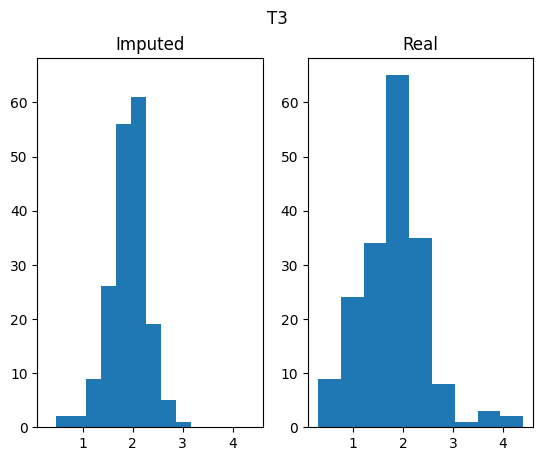

None

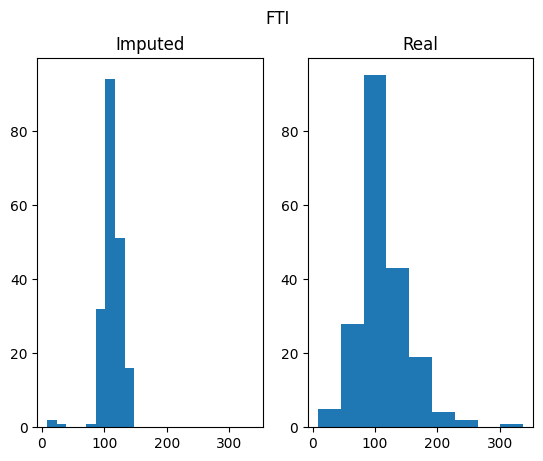

None

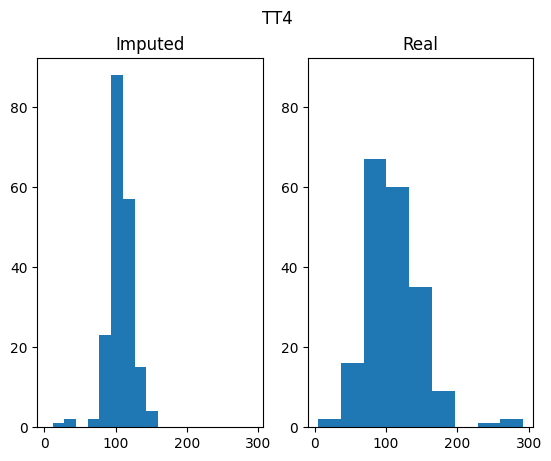

None

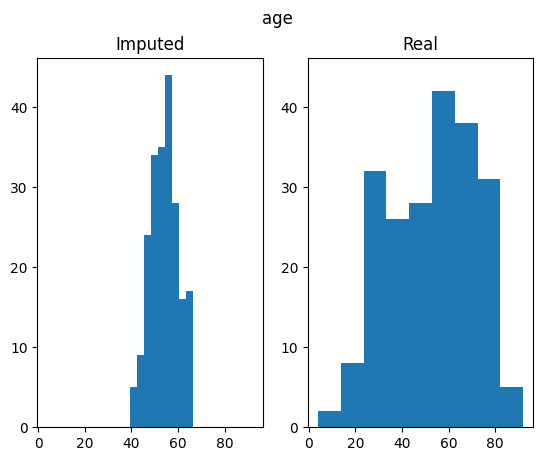

None

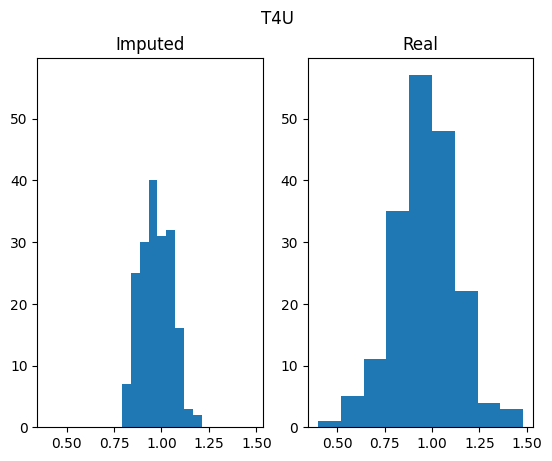

None

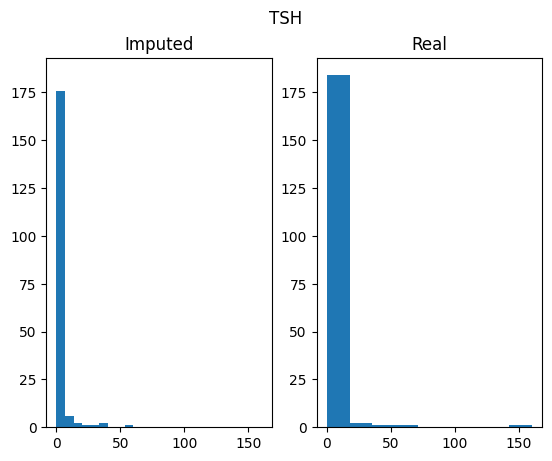

None

In [100]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

## WKNN

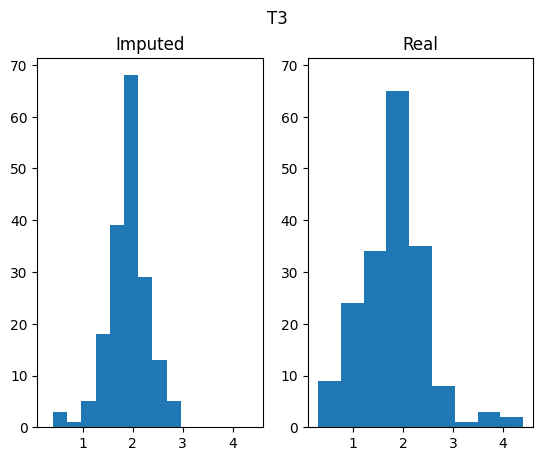

None

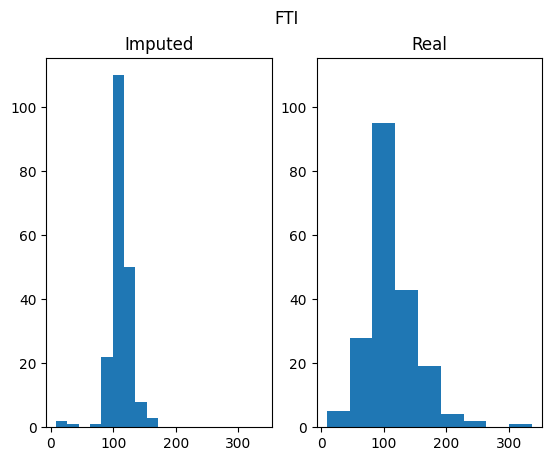

None

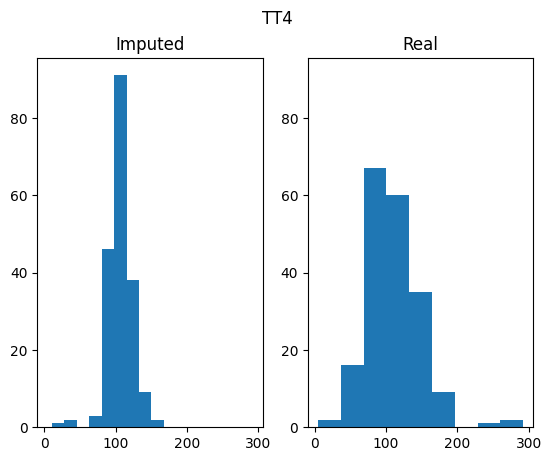

None

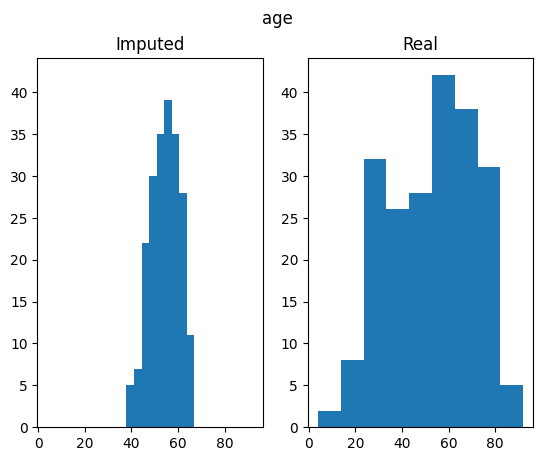

None

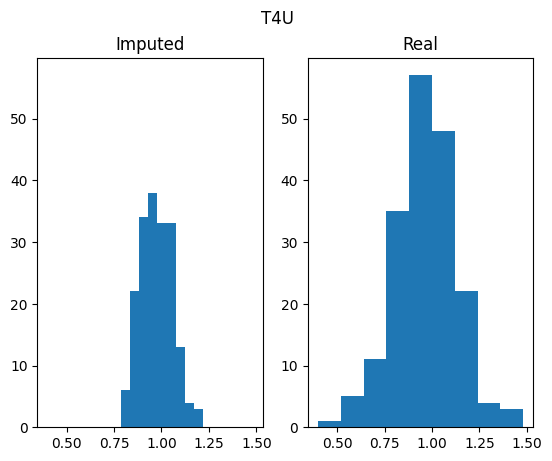

None

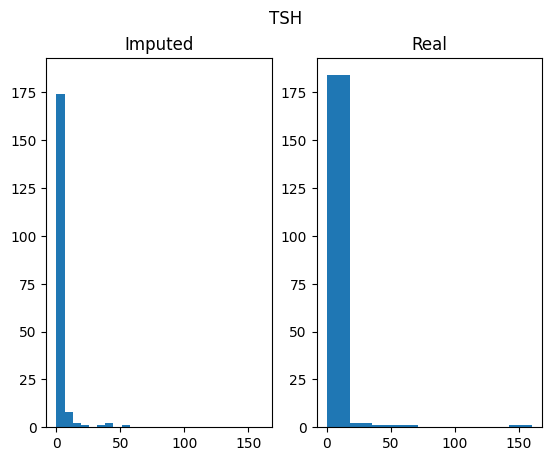

None

In [101]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

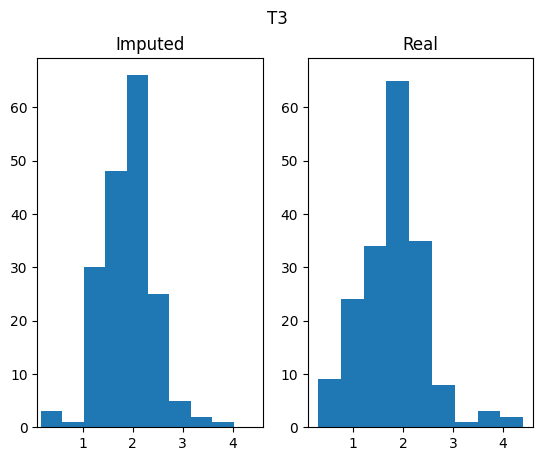

None

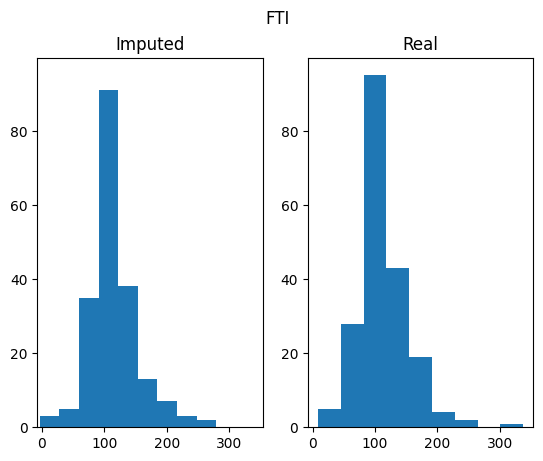

None

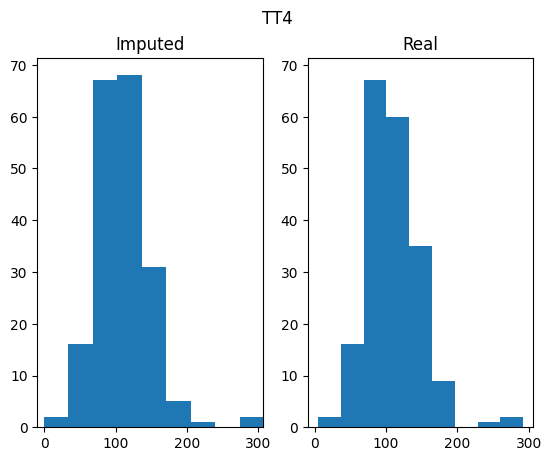

None

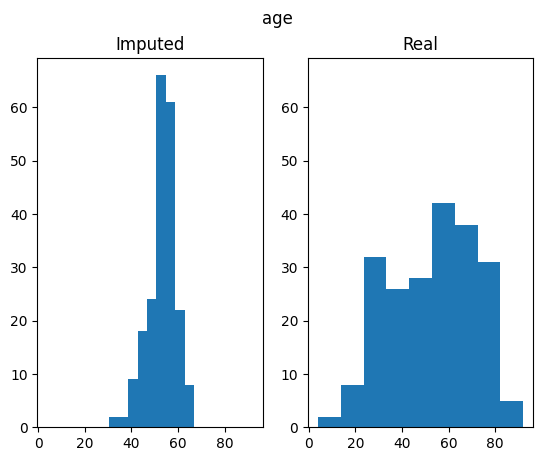

None

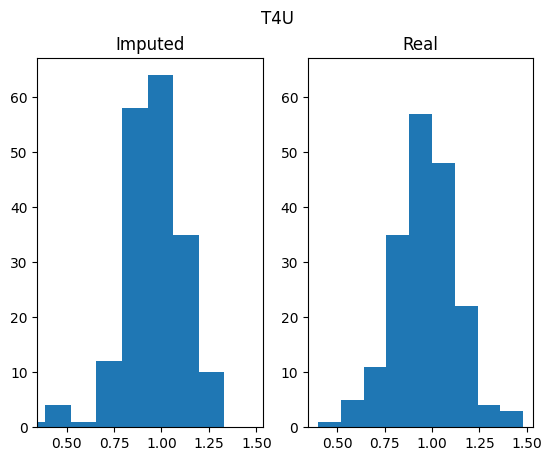

None

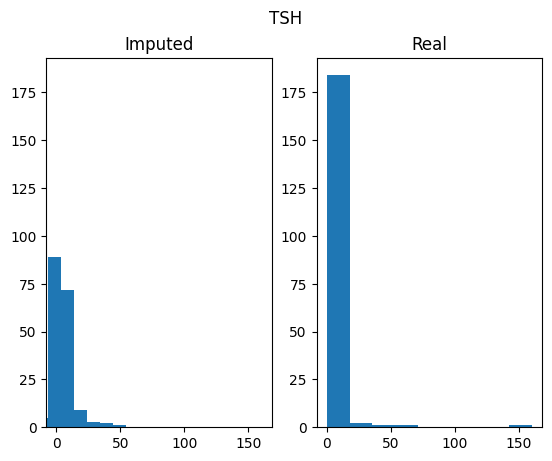

None

In [102]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

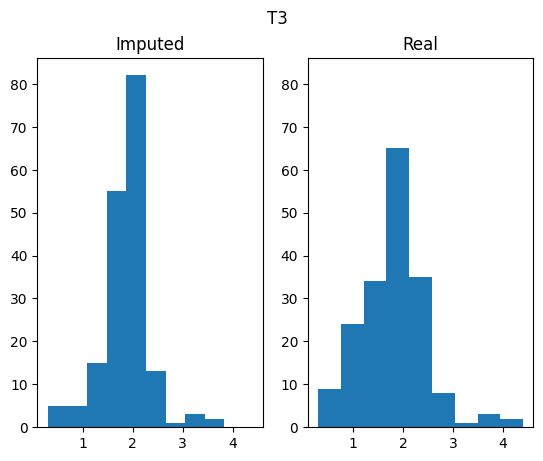

None

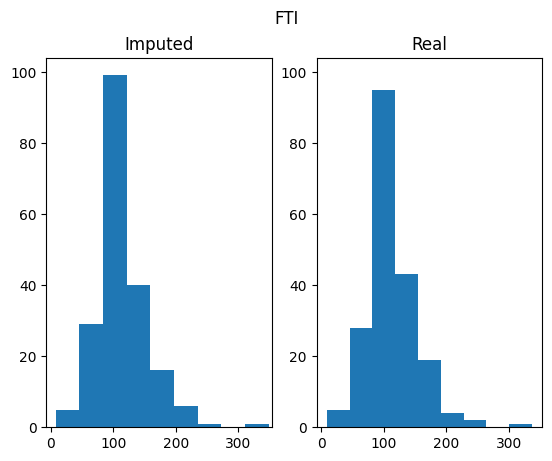

None

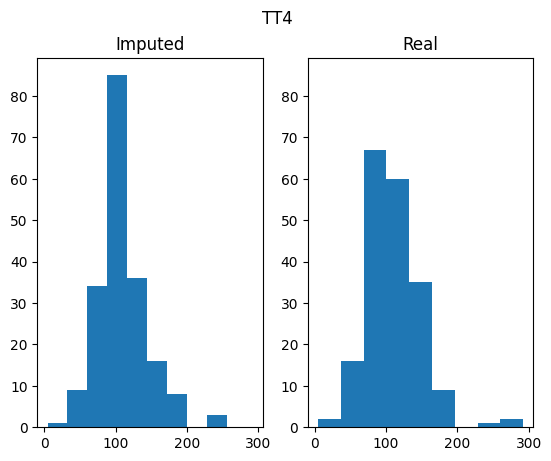

None

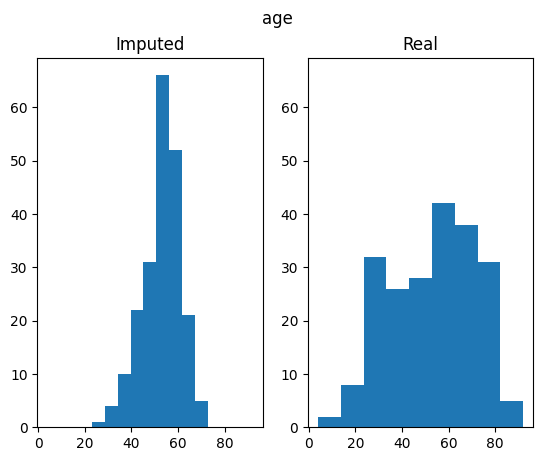

None

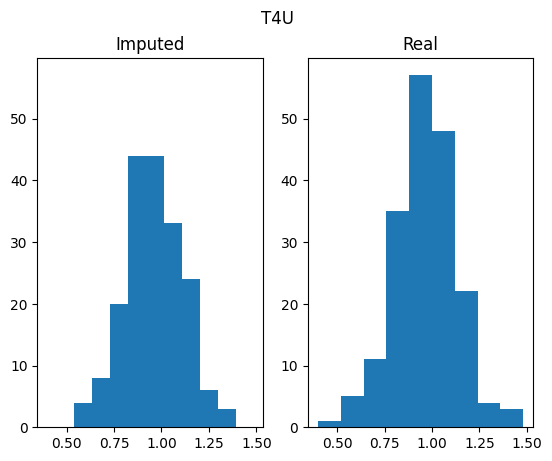

None

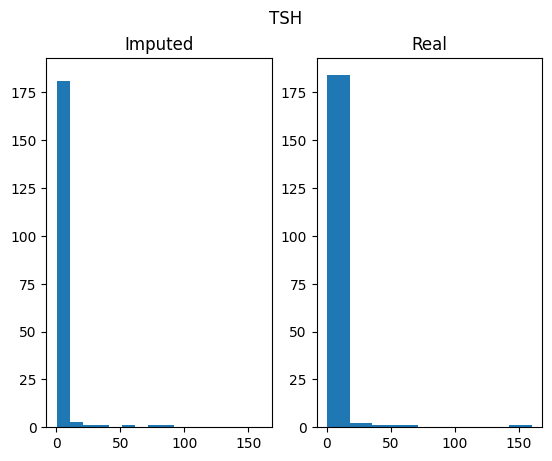

None

In [103]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

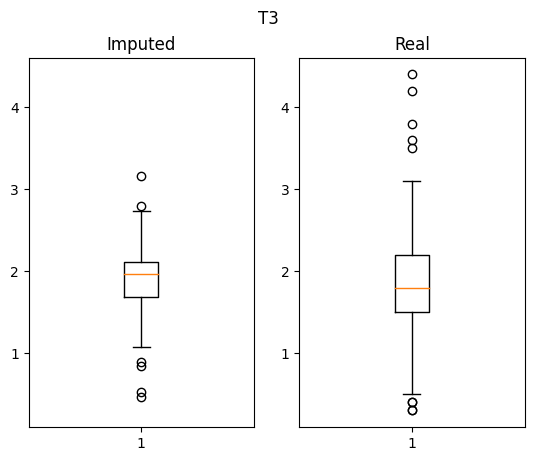

None

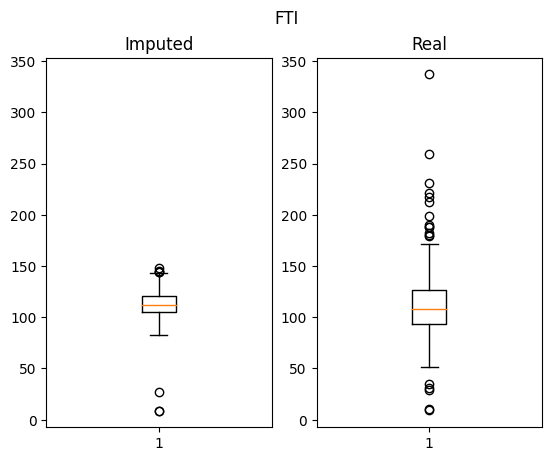

None

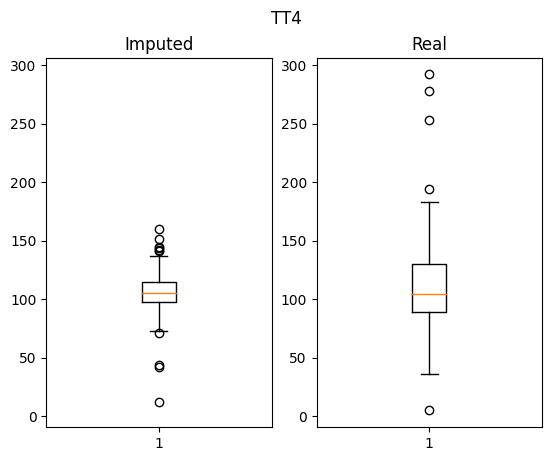

None

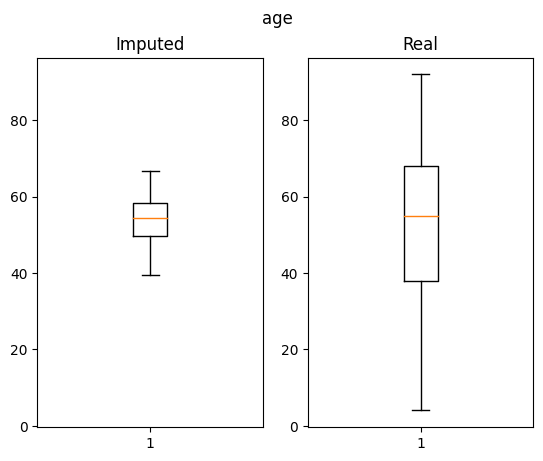

None

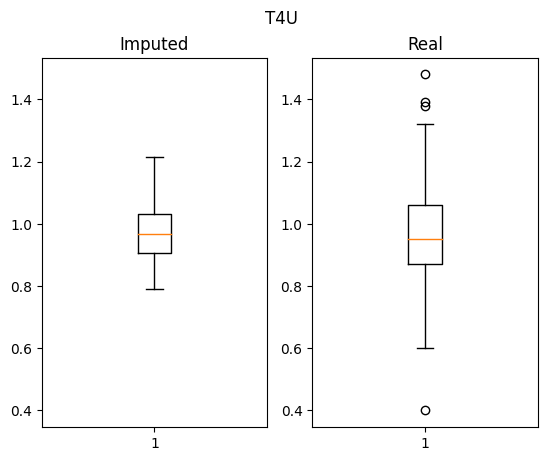

None

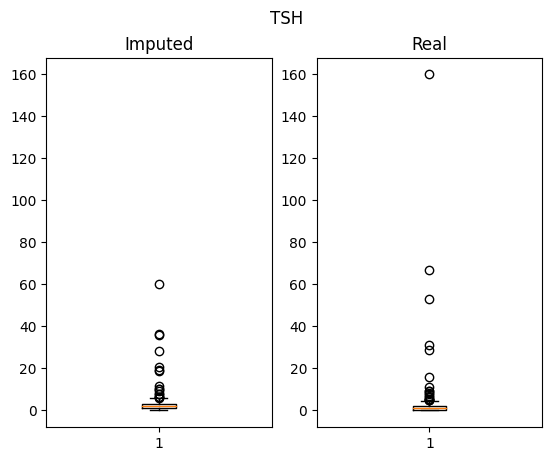

None

In [104]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

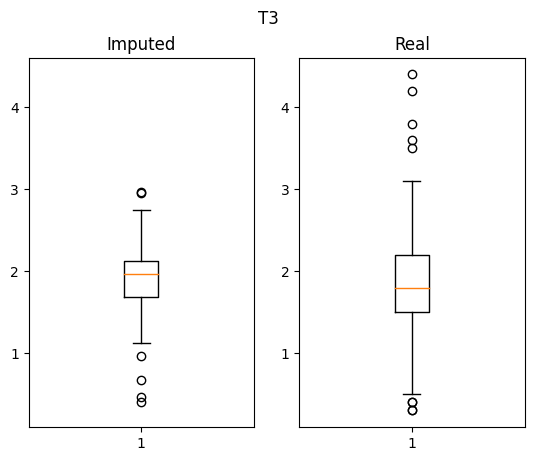

None

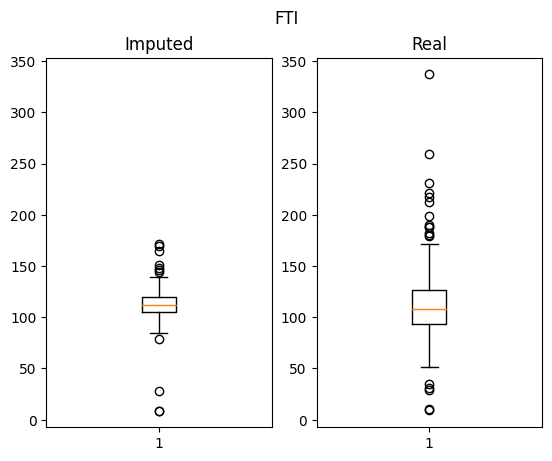

None

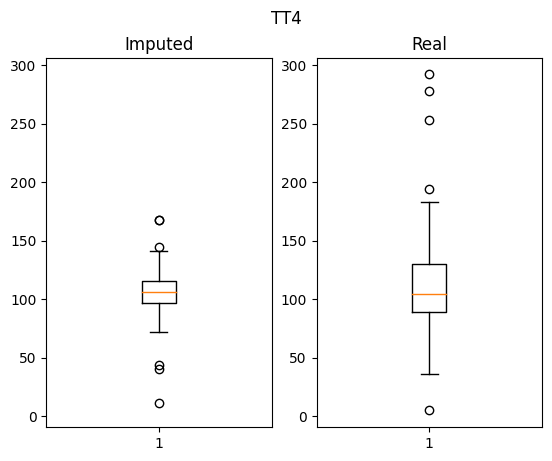

None

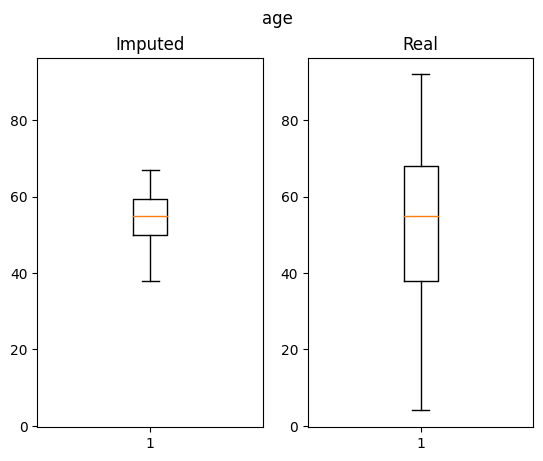

None

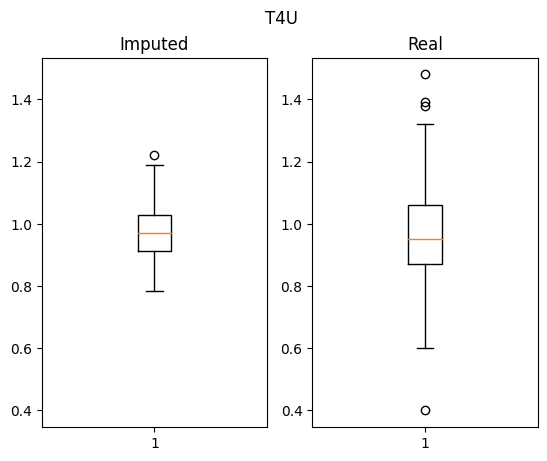

None

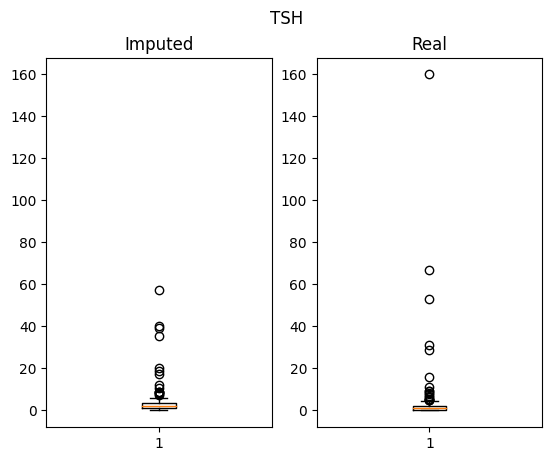

None

In [105]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

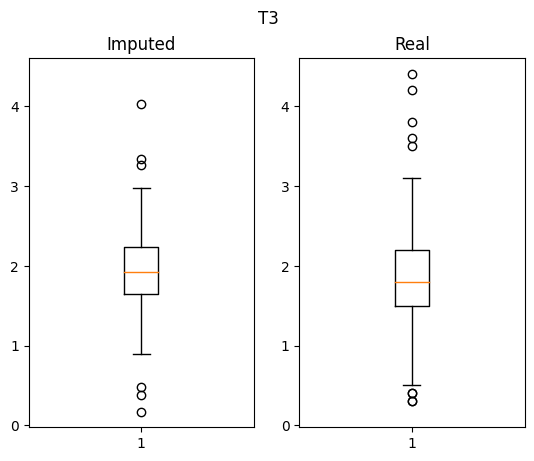

None

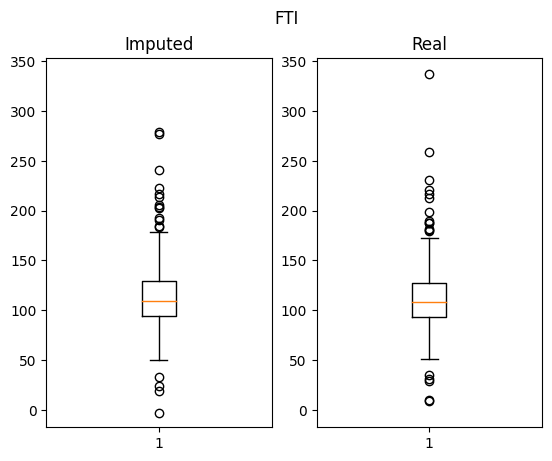

None

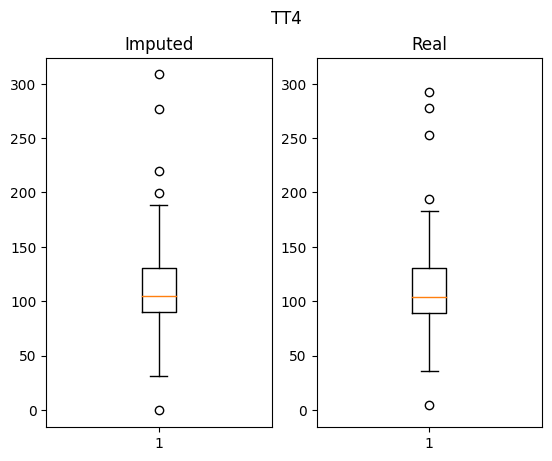

None

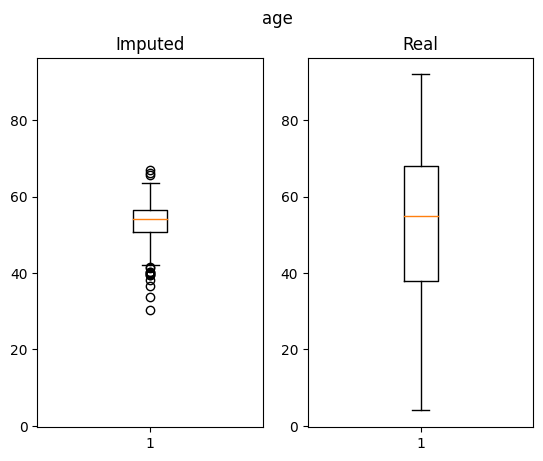

None

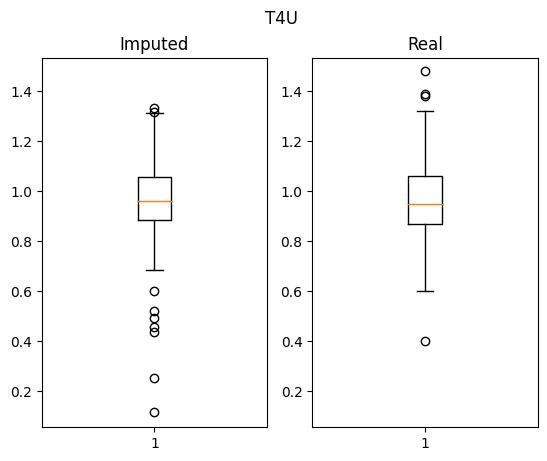

None

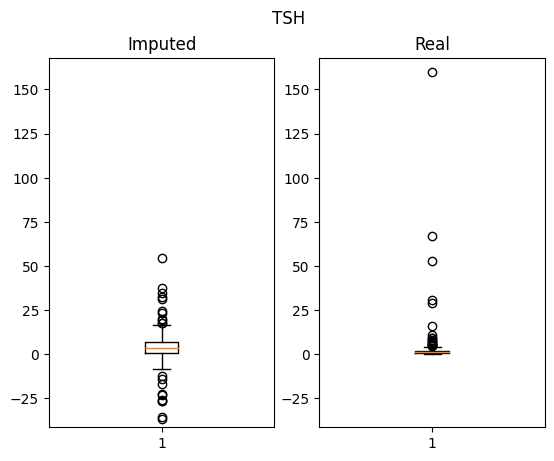

None

In [106]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

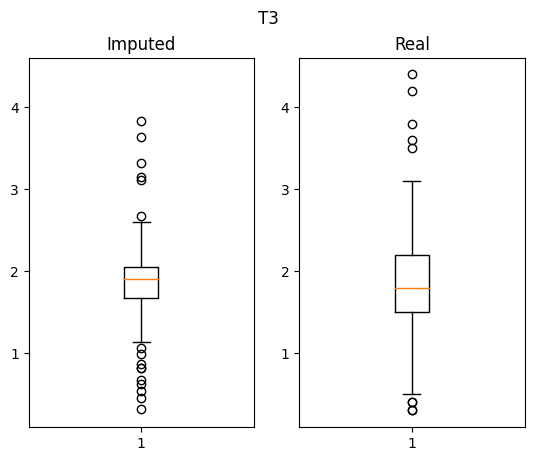

None

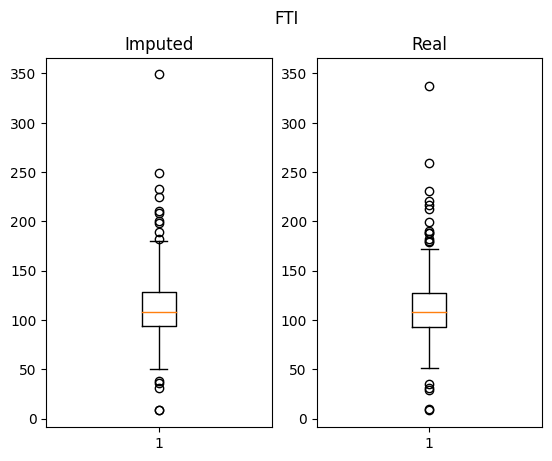

None

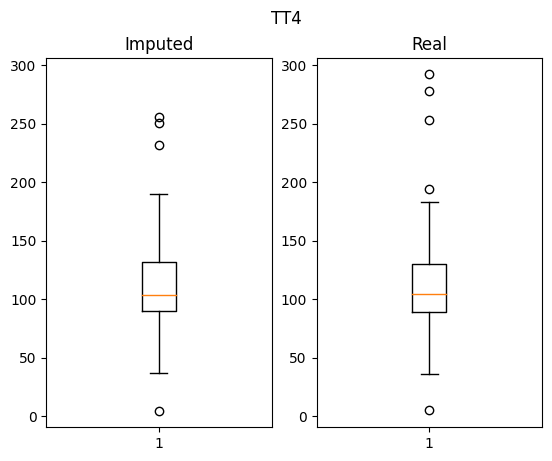

None

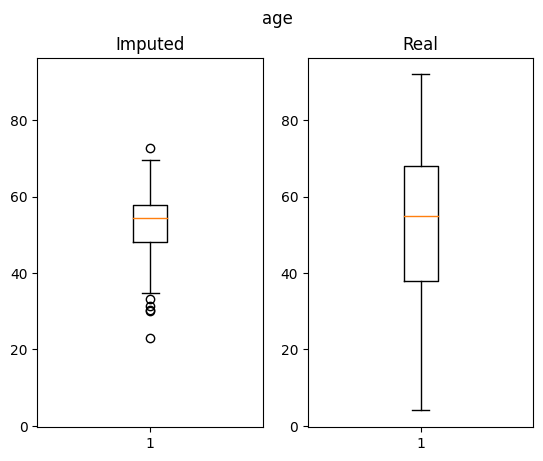

None

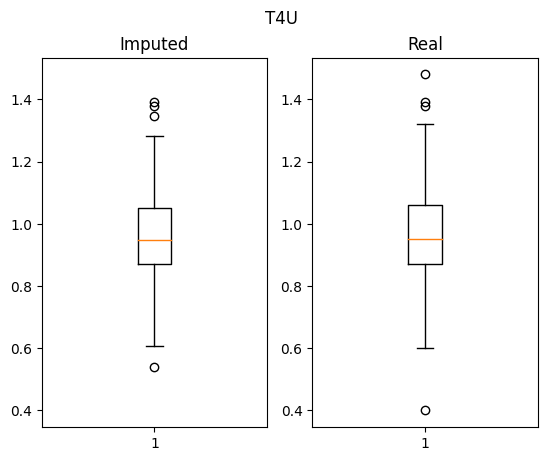

None

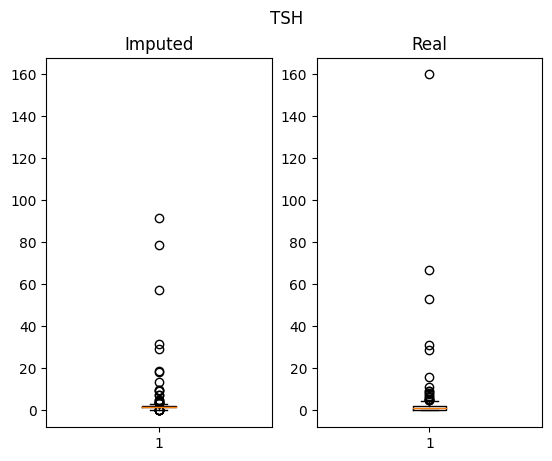

None

In [107]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

In [108]:
imputed_sqr_err(sel_qual_cols, knn_imputed_df)

{'T3': 0.3701842044198895,
 'FTI': 1035.0848670050764,
 'TT4': 950.2482338541666,
 'age': 355.4190566037734,
 'T4U': 0.013582387096774194,
 'TSH': 95.24955511040471}

In [109]:
imputed_sqr_err(sel_qual_cols, wknn_imputed_df)

{'T3': 0.3851467774128787,
 'FTI': 999.0361371360932,
 'TT4': 930.2350089979604,
 'age': 354.157252354841,
 'T4U': 0.014565674790526083,
 'TSH': 100.66113900472351}

In [110]:
imputed_sqr_err(sel_qual_cols, mice_imputed_df)

{'T3': 0.2927733021459556,
 'FTI': 71.81691124581344,
 'TT4': 88.1560524227902,
 'age': 310.11073066371506,
 'T4U': 0.0040660934766222415,
 'TSH': 149.2480602861901}

In [111]:
display(knn_imputed_df[real_cols].mean())
display(knn_imputed_df[imputed_cols].mean())

T3 (real)       1.948487
FTI (real)    113.440277
TT4 (real)    108.774417
age (real)     54.412273
T4U (real)      0.973673
TSH (real)      4.889823
dtype: float64

T3 (imputed)       1.963603
FTI (imputed)    113.051806
TT4 (imputed)    108.185108
age (imputed)     54.659464
T4U (imputed)      0.975255
TSH (imputed)      4.918506
dtype: float64

In [112]:
display(knn_imputed_df[real_cols].std())
display(knn_imputed_df[imputed_cols].std())

T3 (real)      0.787096
FTI (real)    38.032258
TT4 (real)    37.283235
age (real)    18.378102
T4U (real)     0.189116
TSH (real)    23.853609
dtype: float64

T3 (imputed)      0.757270
FTI (imputed)    34.930680
TT4 (imputed)    34.751178
age (imputed)    16.818785
T4U (imputed)     0.180855
TSH (imputed)    23.371398
dtype: float64

In [113]:
display(wknn_imputed_df[real_cols].mean())
display(wknn_imputed_df[imputed_cols].mean())

T3 (real)       1.948487
FTI (real)    113.440277
TT4 (real)    108.774417
age (real)     54.412273
T4U (real)      0.973673
TSH (real)      4.889823
dtype: float64

T3 (imputed)       1.963811
FTI (imputed)    113.099306
TT4 (imputed)    108.159399
age (imputed)     54.650492
T4U (imputed)      0.975529
TSH (imputed)      4.923409
dtype: float64

In [114]:
display(wknn_imputed_df[real_cols].std())
display(wknn_imputed_df[imputed_cols].std())

T3 (real)      0.787096
FTI (real)    38.032258
TT4 (real)    37.283235
age (real)    18.378102
T4U (real)     0.189116
TSH (real)    23.853609
dtype: float64

T3 (imputed)      0.757944
FTI (imputed)    35.055307
TT4 (imputed)    34.812991
age (imputed)    16.840713
T4U (imputed)     0.180841
TSH (imputed)    23.380443
dtype: float64

In [115]:
import seaborn as sns

In [116]:
iter_range = []
for i in range(0, 20):
    iter_range.append(i)

In [117]:
mice_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE", "max_iter", "imputer", "max_iters", iter_range,
                               config={
                                   "random_state": random_state
                               }, estimator_config={})

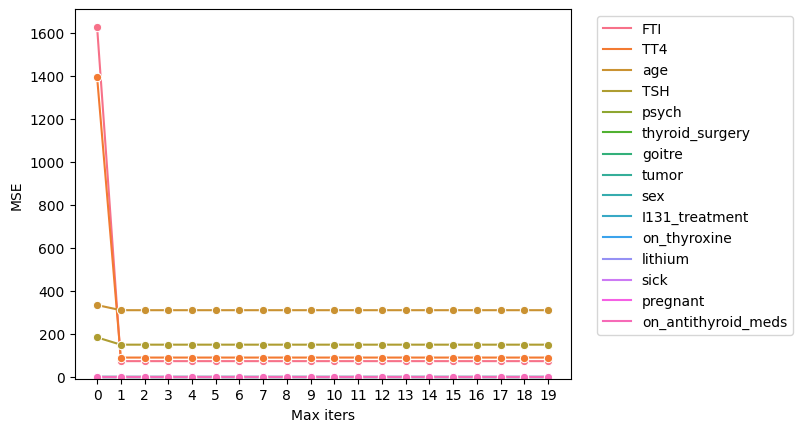

In [118]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] != "T3") & (mice_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

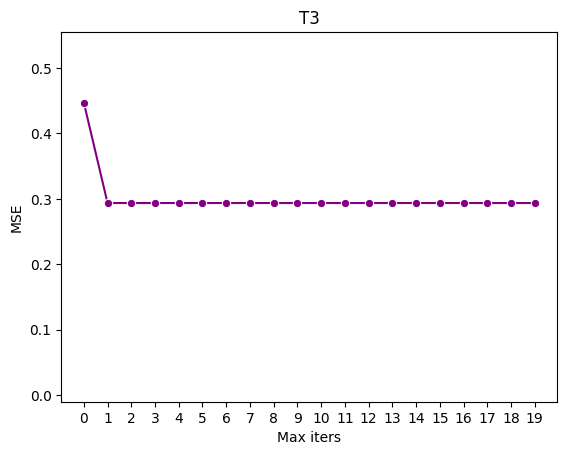

In [119]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

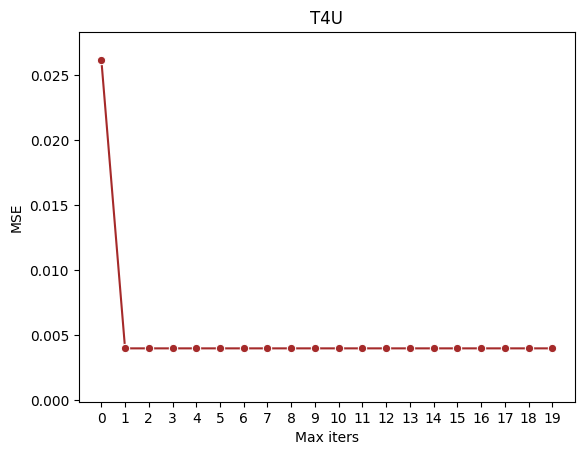

In [120]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [121]:
mice_rf_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_iter", "imputer", "max_iters", iter_range, 
                                  config={
                                      "random_state": random_state
                                      }, estimator_config={
                                          "max_depth": 100,
                                          "random_state": random_state,
                                          "n_estimators": 10,
                                          "max_samples": 0.5,
                                          "bootstrap": True
                                        })

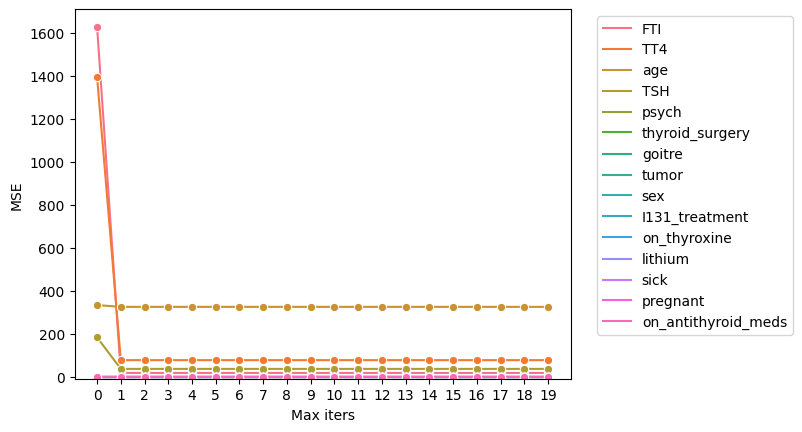

In [122]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] != "T3") & (mice_rf_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

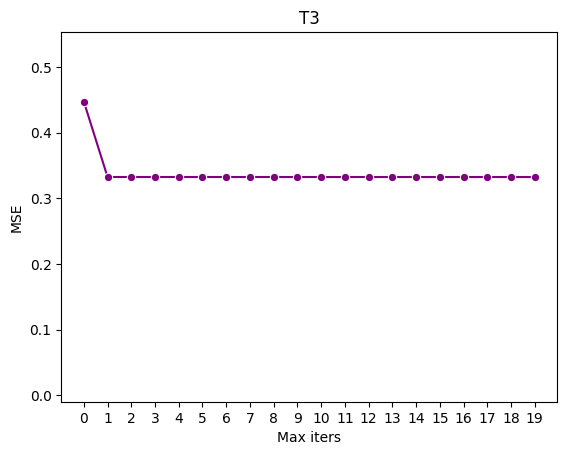

In [123]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

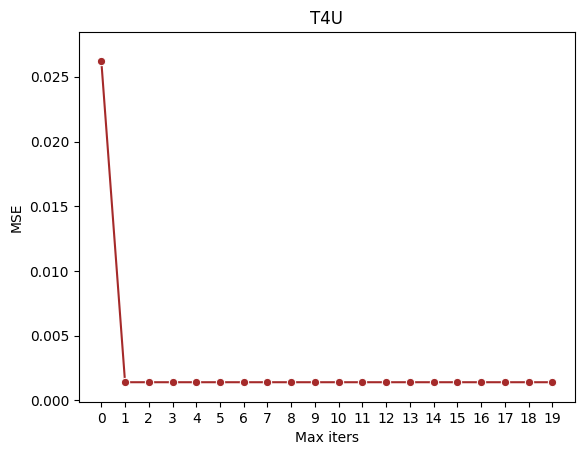

In [124]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [125]:
depths = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]
depth_ticks = [1,5,10,15,20,30,50,100]

In [126]:
mice_rf_depth_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_depth", "estimator", "depth", depths, 
                                        config={
                                            "random_state": random_state,
                                            "max_iter": 100
                                        }, estimator_config={
                                            "random_state": random_state,
                                            "n_estimators": 10,
                                            "max_samples": 0.5,
                                            "bootstrap": True
                                        })

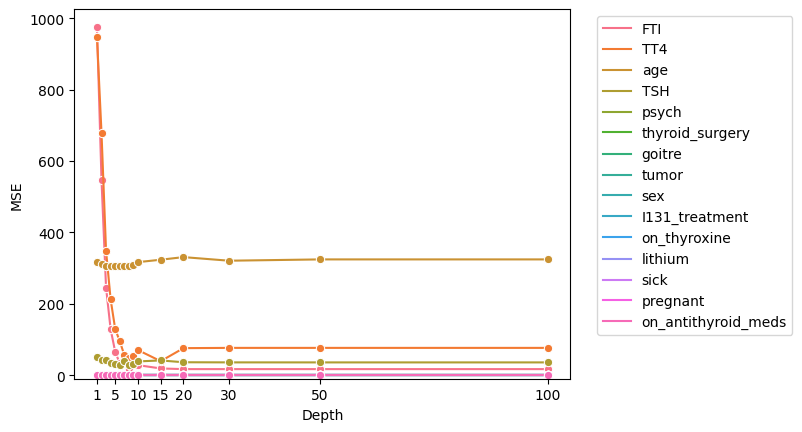

In [127]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] != "T3") & (mice_rf_depth_mse_df["col"] != "T4U")], x="depth", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

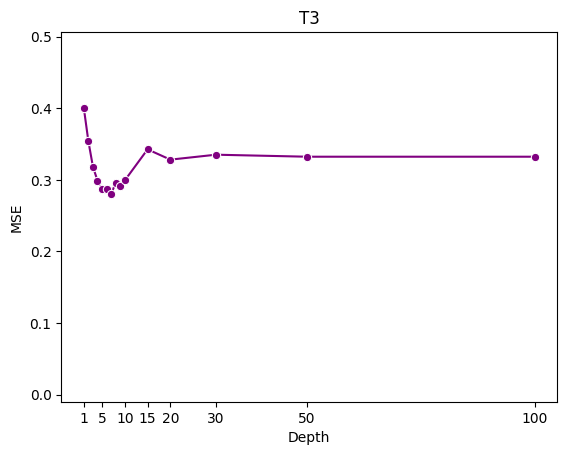

In [128]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T3")], x="depth", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
#plt.xscale("log")
plt.title("T3")
plt.show()

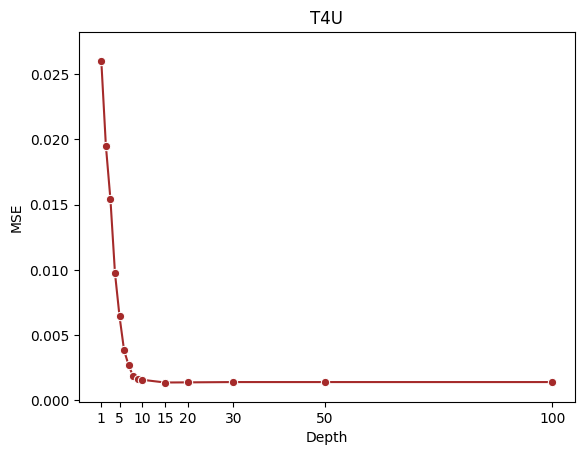

In [129]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T4U")], x="depth", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
#plt.xscale("log")
plt.title("T4U")
plt.show()